# Sprint 8 Project: Supervised Learning

## Introduction

Beta Bank customers are slowly closing their accounts and leaving the bank. It has been discovered that it is cheaper to retain existing customers than to attract new ones. I work as an analyst for Beta Bank and have been tasked with predicting whether a customer will leave the bank soon in order to attempt to keep them.

To accomplish this, I will:
- Download and prepare the data
- Example and prepare classes of data, training models without taking into account class imbalance
- Improve the quality of the models by taking into account class imbalance
- Determine which model is the best fit for the dataset
- Assess model quality by analyzing various performance metrics

My model criteria will be:
- Maximum possible F1 Score that is greater than or equal to 0.59

## Import Libraries

In [1]:
# Import libraries required for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# From sklearn get classification models, model evaluation packages, and training data split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Split dataset for training
from sklearn.model_selection import train_test_split

# For feature scaling
from sklearn.preprocessing import StandardScaler

# For upsampling shuffle
from sklearn.utils import shuffle

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

# Show all columns when displaying dataframe
pd.set_option('display.max_columns', None)

## Read in and Explore Data

### Read in Data

In [2]:
# Read CSV and save as churn dataframe
churn = pd.read_csv('/datasets/Churn.csv')

### Description of Fields in Data
Below is a description for all of the fields in the dataset that I will be working with to build and train my models

**Features**

- *RowNumber* — data string index
- *CustomerId* — unique customer identifier
- *Surname* — surname
- *CreditScore* — credit score
- *Geography* — country of residence
- *Gender* — gender
- *Age* — age
- *Tenure* — period of maturation for a customer’s fixed deposit (years)
- *Balance* — account balance
- *NumOfProducts* — number of banking products used by the customer
- *HasCrCard* — customer has a credit card
- *IsActiveMember* — customer’s activeness
- *EstimatedSalary* — estimated salary

**Target**

- *Exited* — сustomer has left

### Explore Data

In [3]:
# Check for missing values
print('Check for Missing Values')
print(churn.isna().sum())

# Check values for each column
print('\n Describe Dataframe')
print(churn.describe())

# Check data types
print('\n Check Data Types')
print(churn.info())
#print(churn.dtypes)

#Check for duplicate rows
print('\n Check for Duplicate Rows')
print(churn[churn['CustomerId'].duplicated(keep=False)])

# Check data
print('\n Print First 10 Rows')
churn.head(10)

Check for Missing Values
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

 Describe Dataframe
         RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  9091.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800     4.997690   
std     2886.89568  7.193619e+04     96.653299     10.487806     2.894723   
min        1.00000  1.556570e+07    350.000000     18.000000     0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000     2.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000     5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000     7.000000   
max

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


### Data Exploration Observations
- The Tenure column has 909 missing values
- All data types appear to be correct
- There are no duplicated rows (by Customer ID)
- There are several columns that would not be useful for modeling and will be excluded later on:
    - RowNumber
    - CustomerId
    - Surname
    
## Prepare Data for Model Training

In this section, I will:

- Replace missing Tenure values with 0, assuming they are new customers, and change data type to integer (since it's measured in whole years). Another option would be to use the average tenure.
- Exclude extraneous variables not helpful for modeling
    - RowNumber
    - CustomerId
    - Surname
- Process all feature types
    - Categorical features (encoding)
    - Numerical features (feature scaling)
    - *Note: numerical features that are already binary (0 or 1) will not be processed*
- Create training, validation, and test datasets from original dataset

### Replace Missing Values

In [4]:
# Replace missing Tenure values with 0
churn['Tenure'].fillna(0, inplace = True)

# Check to see if missing values were replaced
print(churn['Tenure'].isna().sum())

# Convert Tenure column from float to int
churn['Tenure'] = churn['Tenure'].astype('int64')

# Check datatype
churn['Tenure'].dtype

0


dtype('int64')

### Exclusion of Extraneous Variables

In [5]:
# Remove extraneous fields that will reduce model accuracy 
# Fields to remove are RowNumber, CustomerID, and Surname
# I will leave an intact version of the churn dataframe to analyze class imbalance later on
churn_edited = churn.drop(['RowNumber','Surname','CustomerId'], axis=1)

### Feature Processing

#### Categorical Features

In [6]:
# Checking unique values in the Geography and Gender features
print(churn_edited['Geography'].unique())
print(churn_edited['Gender'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


Since the Geography and Gender features are categorical and have no implicit order or ranking, I will use One-Hot Encoding to process them. I will drop the first dummy variable created by each (one of two Gender columns and one of three Geography columns) to avoid redundancy in the encoding which can confuse models.

After these variables are encoded:
- Gender
    - Gender_Male column will be 1 for Male or 0 for Female
- Geography
    - One of Geography_Germany or Geography_Spain will be 1 for 'Germany' or 'Spain', respectively
    - Both Geography_Germany and Geography_Spain will be 0 indicating 'France'

In [7]:
# Applying One-Hot Encoding to the data
# Dropping the first dummy variable for each to avoid redundancy
# Note that only Geography and Gender are affected without having to specify (they are the only remaining object columns)
churn_edited = pd.get_dummies(churn_edited, drop_first=True)

# Printing the first 5 rows to check for accuracy
churn_edited.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


#### Numerical Features

The numerical features in the data vary widely between each other in magnitude and dispersion. This would cause bias in modeling, so I need to standardize these features before they can be used. *Note: Numerical features that are already binary, such as HasCrCard and IsActiveMember, will not be affected by standardization.*

In [8]:
# Create a list of numeric columns in the churn dataset that need to be scaled
# Note: this does not include categorical variables (either encoded or unencoded)
# The only numerical features in the data are defined below
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

# Apply feature scaling to the numeric fields in the list
scaler = StandardScaler()
scaler.fit(churn_edited[numeric])

# Apply Scaler to Training and Validation Sets
churn_edited[numeric] = scaler.transform(churn_edited[numeric])

# Check Scaled Numeric Features
print(churn_edited.head())

   CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.326221  0.293517 -0.817441 -1.225848      -0.911583          1   
1    -0.440036  0.198164 -1.138838  0.117350      -0.911583          0   
2    -1.536794  0.293517  1.110941  1.333053       2.527057          1   
3     0.501521  0.007457 -1.138838 -1.225848       0.807737          0   
4     2.063884  0.388871 -0.817441  0.785728      -0.911583          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1         0.021886       1                  0   
1               1         0.216534       0                  0   
2               0         0.240687       1                  0   
3               0        -0.108918       0                  0   
4               1        -0.365276       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0          

Now that the categorical features are encoded and the numerical features are standardized and scaled, our data is ready to be split into training, validation, and test sets for my models.

### Splitting Data into Training, Validation, and Test Sets

In [9]:
# Separate target and feature data
# The target variable is 'Exited' because this is what we are trying to predict
# The features are everything remaining, besides 'Exited,' from our data processed above
target = churn_edited['Exited']
features = churn_edited.drop('Exited', axis=1)

# Create Training, Validation, and Test Datasets. The standard ratio is 3:1:1
# First we will split off 40% to get a training dataset of 60% of the data source 
# The validiation set will later be split in half to get 3 datasets with a ratio of 3:1:1
# Set Random State to 12345 to Replicate Training Set in Future
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345)

# Create a validation and test set (50% of validation set each) from the the original validation set
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

# Check the sizes of the training, validation, and test sets for 3:1:1 ratio
# Training 
print(features_train.shape) # Training set contains 60% of original dataframe rows
print(target_train.shape)   # Training set contains 60% of original dataframe rows

# Validation
print(features_valid.shape) # Validation set contains 20% of original dataframe rows
print(target_valid.shape)   # Validation set contains 20% of original dataframe rows

# Test
print(features_test.shape)  # Test set contains 20% of original dataframe rows
print(target_test.shape)    # Test set contains 20% of original dataframe rows

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


The data is now separated into target and features, as well as training, validation, and test sets, for a total of 6 datasets.

## Model Training (Disregarding Class Imbalance)

The task is to create a model to predict the 'Exited' variable, which is either 1 for Yes and 0 for No. Since this is a categorical variable, I have decided to use 3 popular classification algorithms to create models:

- Decision Tree Classifier
- Random Forest Classifier
- Logistic Regression

In this section, I will use the training dataset to train, and specific parameters to improve, each model to predict if customers will soon exit the bank.

### Decision Tree Classifier Model

#### Training and Tuning

In [10]:
# For the Decision Tree Classification Model the parameter that should be tuned is max_depth
# Initialize loop variables
best_result = 0
best_depth = 0

# For tree depth from 1 to 20, calculate the optimal tree depth and evaluate model for greatest F1 score
# I am choosing to use F1 score as the preferred tuning metric because:
# a) We have a target of 0.59 or greater
# b) It is a better metric than accuracy when the data has imbalanced classes
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # Create a model with the given depth
    model.fit(features_train, target_train) # Train the model
    predictions = model.predict(features_valid) # Get the model's predictions
    result = f1_score(target_valid,predictions) # Calculate the F1 score
    if result > best_result:
        best_result = result
        best_depth = depth
    
    # Print model accuracy at each depth
    print("At a depth of", depth, "the F1 score of the model is", round(result, 3))

# Print the F1 score of the model and which depth produced the greatest F1 score 
print()
print("The F1 score of the best model is", round(best_result,3), "at a depth of", best_depth)

At a depth of 1 the F1 score of the model is 0.0
At a depth of 2 the F1 score of the model is 0.522
At a depth of 3 the F1 score of the model is 0.423
At a depth of 4 the F1 score of the model is 0.553
At a depth of 5 the F1 score of the model is 0.541
At a depth of 6 the F1 score of the model is 0.57
At a depth of 7 the F1 score of the model is 0.532
At a depth of 8 the F1 score of the model is 0.545
At a depth of 9 the F1 score of the model is 0.579
At a depth of 10 the F1 score of the model is 0.529
At a depth of 11 the F1 score of the model is 0.521
At a depth of 12 the F1 score of the model is 0.502
At a depth of 13 the F1 score of the model is 0.526
At a depth of 14 the F1 score of the model is 0.483
At a depth of 15 the F1 score of the model is 0.503
At a depth of 16 the F1 score of the model is 0.492
At a depth of 17 the F1 score of the model is 0.471
At a depth of 18 the F1 score of the model is 0.491
At a depth of 19 the F1 score of the model is 0.492
At a depth of 20 the F1 

#### Model Performance Metrics

In [11]:
# Use Decision Tree Model for classification with depth of 9 (from above results)
model = DecisionTreeClassifier(random_state=12345, max_depth=9)

# Fit Model to Training Dataset
model.fit(features_train, target_train)

# Use Model to Predict Target Values on Validation Set
predicted_valid = model.predict(features_valid)

# Print Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(target_valid, predicted_valid))

# Get Accuracy Score 
accuracy_valid = accuracy_score(target_valid, predicted_valid)

# Print Model Accuracy 
print("\nAt a max depth of 9, the accuracy of the model is", round(accuracy_valid, 3))

# Print Recall Score
print('The Recall Score is', round(recall_score(target_valid, predicted_valid), 3))

# Print Precision Score 
print('The Precision Score is', round(precision_score(target_valid, predicted_valid), 3))

# Print F1 Score 
print('The F1 Score is', round(f1_score(target_valid, predicted_valid), 3))

# Calculate and Print AUC-ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC-ROC Score is', round(auc_roc, 3))

Confusion Matrix
[[1494   88]
 [ 212  206]]

At a max depth of 9, the accuracy of the model is 0.85
The Recall Score is 0.493
The Precision Score is 0.701
The F1 Score is 0.579
The AUC-ROC Score is 0.79


### Random Forest Classifier Model

#### Training and Tuning

In [12]:
# For the Decision Tree Classification Model the parameters that should be tuned are n_estimators and max_depth
# Initialize loop variables
best_result = 0
best_est = 0
best_depth = 0

# For number of estimators and max depth each between 1 and 20, calculate the optimal value for each parameter and evaluate model for greatest F1 score
# I am choosing to use F1 score as the preferred tuning metric because:
# a) We have a target of 0.59 or greater 
# b) It is a better metric than accuracy when the data has imbalanced classes
for est in range(1, 21):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # Create a model with the given parameters
        model.fit(features_train, target_train) # Train the model
        predictions = model.predict(features_valid) # Get the model's predictions
        result = f1_score(target_valid,predictions) # Calculate the F1 score
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth
    
    # Print model F1 score at each depth
        print("At a number of estimators of", est, "and max depth", depth, "the F1 score of the model is", round(result,3))

# Print the F1 score of the model and which number of estimators produced the greatest F1 score
print()
print("The F1 score of the best model is", round(best_result,3), "with a number of estimators of", best_est, "and max depth", best_depth)

At a number of estimators of 1 and max depth 1 the F1 score of the model is 0.248
At a number of estimators of 1 and max depth 2 the F1 score of the model is 0.248
At a number of estimators of 1 and max depth 3 the F1 score of the model is 0.223
At a number of estimators of 1 and max depth 4 the F1 score of the model is 0.439
At a number of estimators of 1 and max depth 5 the F1 score of the model is 0.435
At a number of estimators of 1 and max depth 6 the F1 score of the model is 0.424
At a number of estimators of 1 and max depth 7 the F1 score of the model is 0.533
At a number of estimators of 1 and max depth 8 the F1 score of the model is 0.526
At a number of estimators of 1 and max depth 9 the F1 score of the model is 0.521
At a number of estimators of 1 and max depth 10 the F1 score of the model is 0.531
At a number of estimators of 1 and max depth 11 the F1 score of the model is 0.494
At a number of estimators of 1 and max depth 12 the F1 score of the model is 0.521
At a number o

At a number of estimators of 6 and max depth 4 the F1 score of the model is 0.498
At a number of estimators of 6 and max depth 5 the F1 score of the model is 0.471
At a number of estimators of 6 and max depth 6 the F1 score of the model is 0.531
At a number of estimators of 6 and max depth 7 the F1 score of the model is 0.56
At a number of estimators of 6 and max depth 8 the F1 score of the model is 0.544
At a number of estimators of 6 and max depth 9 the F1 score of the model is 0.581
At a number of estimators of 6 and max depth 10 the F1 score of the model is 0.577
At a number of estimators of 6 and max depth 11 the F1 score of the model is 0.554
At a number of estimators of 6 and max depth 12 the F1 score of the model is 0.568
At a number of estimators of 6 and max depth 13 the F1 score of the model is 0.582
At a number of estimators of 6 and max depth 14 the F1 score of the model is 0.549
At a number of estimators of 6 and max depth 15 the F1 score of the model is 0.549
At a number

At a number of estimators of 11 and max depth 5 the F1 score of the model is 0.474
At a number of estimators of 11 and max depth 6 the F1 score of the model is 0.546
At a number of estimators of 11 and max depth 7 the F1 score of the model is 0.55
At a number of estimators of 11 and max depth 8 the F1 score of the model is 0.548
At a number of estimators of 11 and max depth 9 the F1 score of the model is 0.573
At a number of estimators of 11 and max depth 10 the F1 score of the model is 0.568
At a number of estimators of 11 and max depth 11 the F1 score of the model is 0.576
At a number of estimators of 11 and max depth 12 the F1 score of the model is 0.587
At a number of estimators of 11 and max depth 13 the F1 score of the model is 0.593
At a number of estimators of 11 and max depth 14 the F1 score of the model is 0.578
At a number of estimators of 11 and max depth 15 the F1 score of the model is 0.596
At a number of estimators of 11 and max depth 16 the F1 score of the model is 0.59

At a number of estimators of 16 and max depth 5 the F1 score of the model is 0.501
At a number of estimators of 16 and max depth 6 the F1 score of the model is 0.553
At a number of estimators of 16 and max depth 7 the F1 score of the model is 0.551
At a number of estimators of 16 and max depth 8 the F1 score of the model is 0.551
At a number of estimators of 16 and max depth 9 the F1 score of the model is 0.567
At a number of estimators of 16 and max depth 10 the F1 score of the model is 0.572
At a number of estimators of 16 and max depth 11 the F1 score of the model is 0.589
At a number of estimators of 16 and max depth 12 the F1 score of the model is 0.598
At a number of estimators of 16 and max depth 13 the F1 score of the model is 0.584
At a number of estimators of 16 and max depth 14 the F1 score of the model is 0.576
At a number of estimators of 16 and max depth 15 the F1 score of the model is 0.587
At a number of estimators of 16 and max depth 16 the F1 score of the model is 0.5

#### Model Performance Metrics

In [13]:
# Use Random Forest Model for classification with 14 estimators and max depth 13 (from above results)
model = RandomForestClassifier(random_state=12345, n_estimators=14, max_depth=13)

# Fit Model to Traing Dataset
model.fit(features_train, target_train)

# Use Model to Predict Target Values on Validation Set
predicted_valid = model.predict(features_valid)

# Print Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(target_valid, predicted_valid))

# Get Accuracy Score 
accuracy_valid = accuracy_score(target_valid, predicted_valid)

# Print Model Accuracy 
print("\nWith 14 estimators and a max depth of 13, the accuracy of the model is", round(accuracy_valid, 3))

# Print Recall Score
print('The Recall Score is', round(recall_score(target_valid, predicted_valid), 3))

# Print Precision Score 
print('The Precision Score is', round(precision_score(target_valid, predicted_valid), 3))

# Print F1 Score 
print('The F1 Score is', round(f1_score(target_valid, predicted_valid), 3))

# Calculate and Print AUC-ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC-ROC Score is', round(auc_roc, 3))

Confusion Matrix
[[1528   54]
 [ 216  202]]

With 14 estimators and a max depth of 13, the accuracy of the model is 0.865
The Recall Score is 0.483
The Precision Score is 0.789
The F1 Score is 0.599
The AUC-ROC Score is 0.836


### Logistic Regression Model

#### Training and Performance Metrics

In [14]:
# Create a Logistic Regression Model
model = LogisticRegression(random_state=12345, solver="liblinear")

# Fit the model to the traning dataset
model.fit(features_train, target_train)

# Score the model accuracy on the validation dataset
# I am choosing to use F1 score as the preferred tuning metric because:
# a) We have a target of 0.59 or greater 
# b) It is a better metric than accuracy when the data has imbalanced classes
predicted_valid = model.predict(features_valid)
score_valid = f1_score(target_valid, predicted_valid)

# Print Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(target_valid, predicted_valid))

# Print Accuracy Score
print('\nThe Accuracy Score of the logistic regression model on the validation dataset is', round(accuracy_score(target_valid, predicted_valid), 3))

# Print Recall Score
print('The Recall Score is', round(recall_score(target_valid, predicted_valid), 3))

# Print Precision Score 
print('The Precision Score is', round(precision_score(target_valid, predicted_valid), 3))

# Print the F1 scores of the model on the training and validation datasets
print("The F1 score is", round(score_valid, 3))

# Calculate and Print AUC-ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC-ROC Score is', round(auc_roc, 3))

Confusion Matrix
[[1506   76]
 [ 319   99]]

The Accuracy Score of the logistic regression model on the validation dataset is 0.802
The Recall Score is 0.237
The Precision Score is 0.566
The F1 score is 0.334
The AUC-ROC Score is 0.759


## Address Class Imbalance in the Data

Class imbalance in the dataset can be handled in several ways:

- Class Weight Adjustment — In order to indicate that some observations are more important than others, we can assign a weight to the respective class by using the parameter class_weight='balanced' in our classification models. The algorithm will calculate how many times the class "0" occurs more often than the class "1". We’ll denote this number as N (an unknown number of times). Because of this, rare class will have a higher weight.
- Resampling
    - Upsampling — Determine the class with fewer observations - the rare class. Duplicate the rarer class observations several times. Create a new training sample based on the data obtained. The most important tasks are repeated several times to make them easier to remember for the model.
    - Downsampling — Determine the class with more observations - the majority class. We can randomly drop a portion of majority class observations to remove noise for the model to more easily find rare observations.

### Class Weight Adjustment

This step will be performed in Section 7 by including the parameter class_weight='balanced' in each classification model.

### Resampling (Upsampling and Downsampling)

There may exist a variable among both the features and target that is overrepresented or underrepresented in the data. This is problematic and may cause the model to not appropriately consider those variables when being trained. To check how this should be applied to the data, I will take a closer look at the features and target individually for any patterns or observations.

array([[<AxesSubplot:title={'center':'RowNumber'}>,
        <AxesSubplot:title={'center':'CustomerId'}>,
        <AxesSubplot:title={'center':'CreditScore'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Tenure'}>,
        <AxesSubplot:title={'center':'Balance'}>],
       [<AxesSubplot:title={'center':'NumOfProducts'}>,
        <AxesSubplot:title={'center':'HasCrCard'}>,
        <AxesSubplot:title={'center':'IsActiveMember'}>],
       [<AxesSubplot:title={'center':'EstimatedSalary'}>,
        <AxesSubplot:title={'center':'Exited'}>, <AxesSubplot:>]],
      dtype=object)

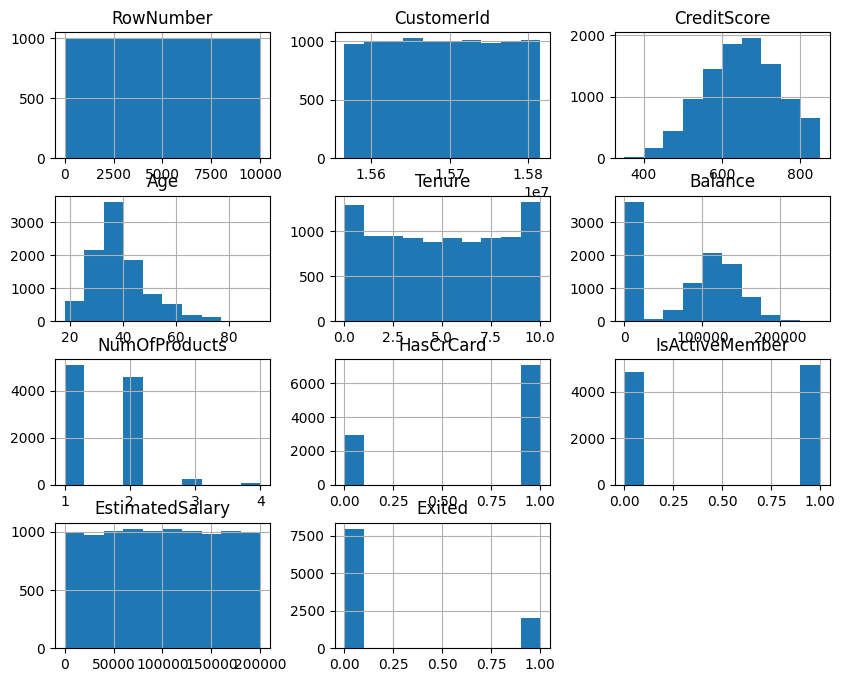

In [15]:
# Checking for underrepresented or overrepresented features that may need to be upsampled or downsampled, respectively
# Quick histogram of each variable for an overview, from the original dataframe for clarity
churn.hist(figsize=(10, 8))

Percentage of customers that left the bank: 20.369999999999997

37    478
38    477
35    474
36    456
34    447
     ... 
92      2
88      1
82      1
85      1
83      1
Name: Age, Length: 70, dtype: int64

Median age: 37.0
Mean age: 38.92
Percentage of customers above age 55: 8.0

0.00         3617
105473.74       2
130170.82       2
72594.00        1
139723.90       1
             ... 
130306.49       1
92895.56        1
132005.77       1
166287.85       1
104001.38       1
Name: Balance, Length: 6382, dtype: int64

Percentage of customers with zero balances: 36.17


Text(0.5, 0, 'Age')

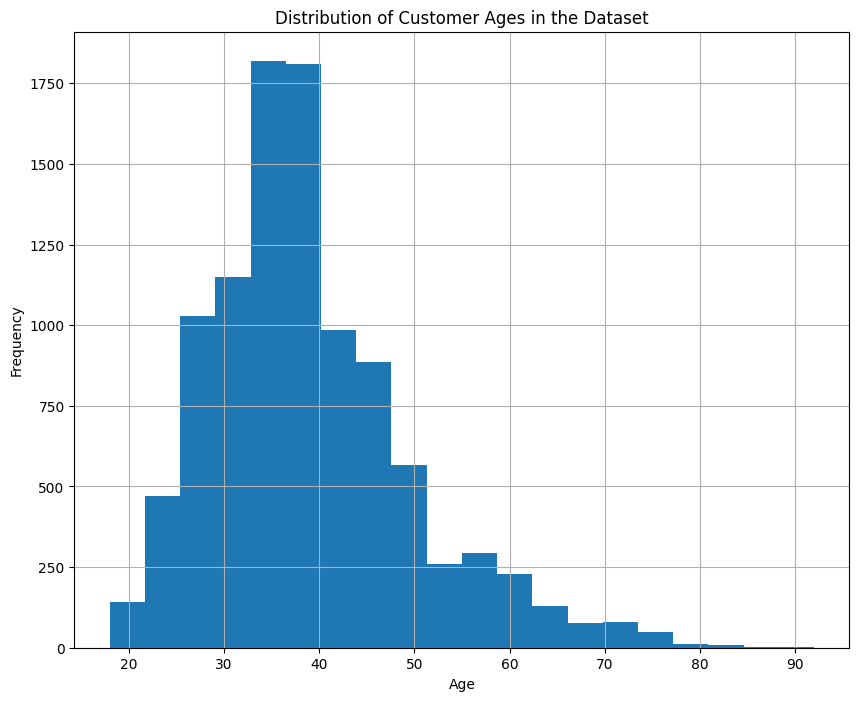

In [16]:
# Checking the class balance of Exited (target)
print("Percentage of customers that left the bank:", churn[churn['Exited'] == 1].shape[0] / len(churn) * 100)
print()
# Checking characteristics of the Age and Balance features for class imbalance
print(churn['Age'].value_counts())
print()
print("Median age:", churn['Age'].median())
print("Mean age:", churn['Age'].mean().round(2))
print("Percentage of customers above age 55:", churn[churn['Age'] > 55].shape[0] / len(churn) * 100)
print()
print(churn['Balance'].value_counts())
print()
print("Percentage of customers with zero balances:", churn[churn['Balance'] == 0].shape[0] / len(churn) * 100)


# More detailed histogram of Age feature from original data
churn['Age'].hist(figsize=(10, 8), bins=20)
plt.title('Distribution of Customer Ages in the Dataset')
plt.ylabel('Frequency')
plt.xlabel('Age')

Based on the analysis above, the features with the most class imbalance are Age and Balance. To address each, I would:
- Upsample data for individuals above age 55 due to underrepresentation (only 8% of customers are above age 55)
- Downsample those with Balances of $0.00 due to overrepresentation (36.17% of customers have a zero balance)

However, it is easier to perform the upsampling more generally, based on the target imbalance:
- 20.37% of customers in the dataset left the bank, making this an underrepresented class

I will perform upsampling based on the target. The data corresponding to those who exited the bank will be multiplied by 10 and randomly shuffled back into the dataset.

In [17]:
# Create function for upsampling
# Function will return an upsampled feature and target traning set to train the model on 
# Upsample function will multiply positive class observations by 10 and then shuffle the results to create a new training set
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

# Return upsampled traning sets
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

I have now created adjusted datasets to more accurately reflect the bank's customers. These new datasets will be used along with the parameter class_weight='balanced' in each algorithm.

## Model Training (Accounting for Class Imbalance)

I will revisit the same 3 algorithms as above but using the adjusted (upsampled) datasets and class_weight parameter:
- Decision Tree Classifier
- Random Forest Classifier
- Logistic Regression

### Decision Tree Classifier Model

#### Training and Tuning

In [18]:
# For the Decision Tree Classification Model the parameter that should be tuned is max_depth
# Initialize loop variables
best_result = 0
best_depth = 0

# For tree depth from 1 to 20, calculate the optimal tree depth and evaluate model for greatest F1 score
# I am choosing to use F1 score as the preferred tuning metric because:
# a) We have a target of 0.59 or greater
# b) It is a better metric than accuracy when the data has imbalanced classes
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') # Create a model with the given depth
    model.fit(features_upsampled, target_upsampled) # Train the model
    predictions = model.predict(features_valid) # Get the model's predictions
    result = f1_score(target_valid, predictions) # Calculate the F1 score
    if result > best_result:
        best_result = result
        best_depth = depth
    
    # Print model accuracy at each depth
    print("At a depth of", depth, "the F1 score of the model is", round(result, 3))

# Print the F1 score of the model and which depth produced the greatest F1 score 
print()
print("The F1 score of the best model is", round(best_result, 3), "at a depth of", best_depth)

At a depth of 1 the F1 score of the model is 0.499
At a depth of 2 the F1 score of the model is 0.541
At a depth of 3 the F1 score of the model is 0.541
At a depth of 4 the F1 score of the model is 0.528
At a depth of 5 the F1 score of the model is 0.596
At a depth of 6 the F1 score of the model is 0.561
At a depth of 7 the F1 score of the model is 0.556
At a depth of 8 the F1 score of the model is 0.539
At a depth of 9 the F1 score of the model is 0.532
At a depth of 10 the F1 score of the model is 0.517
At a depth of 11 the F1 score of the model is 0.527
At a depth of 12 the F1 score of the model is 0.512
At a depth of 13 the F1 score of the model is 0.506
At a depth of 14 the F1 score of the model is 0.497
At a depth of 15 the F1 score of the model is 0.487
At a depth of 16 the F1 score of the model is 0.485
At a depth of 17 the F1 score of the model is 0.47
At a depth of 18 the F1 score of the model is 0.489
At a depth of 19 the F1 score of the model is 0.465
At a depth of 20 the F

#### Model Performance Metrics

In [19]:
# Use Decision Tree Model for classification with depth of 5 (from above results)
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')

# Fit Model to Traing Dataset
model.fit(features_upsampled, target_upsampled)

# Use Model to Predict Target Values on Validation Set
predicted_valid = model.predict(features_valid)

# Print Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(target_valid, predicted_valid))

# Get Accuracy Score 
accuracy_valid = accuracy_score(target_valid, predicted_valid)

# Print Model Accuracy 
print("\nWith a max depth of 5, the accuracy of the model is", round(accuracy_valid, 3))

# Print Recall Score
print('The Recall Score is', round(recall_score(target_valid, predicted_valid), 3))

# Print Precision Score 
print('The Precision Score is', round(precision_score(target_valid, predicted_valid), 3))

# Print F1 Score 
print('The F1 Score is', round(f1_score(target_valid, predicted_valid), 3))

# Calculate and Print AUC-ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC-ROC Score is', round(auc_roc, 3))

Confusion Matrix
[[1341  241]
 [ 138  280]]

With a max depth of 5, the accuracy of the model is 0.81
The Recall Score is 0.67
The Precision Score is 0.537
The F1 Score is 0.596
The AUC-ROC Score is 0.831


### Random Forest Classification Model

#### Training and Tuning

In [20]:
# For the Random Forest Classification Model the parameter that should be tuned is n_estimators
# Initialize loop variables
best_result = 0
best_est = 0
best_depth = 0

# For number of estimators and max depth each between 1 and 20, calculate the optimal value of each parameter and evaluate model for greatest F1 score
# I am choosing to use F1 score as the preferred tuning metric because:
# a) We have a target of 0.59 or greater 
# b) It is a better metric than accuracy when the data has imbalanced classes
for est in range(1, 21):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') # Create a model with the given parameters
        model.fit(features_upsampled, target_upsampled) # Train the model
        predictions = model.predict(features_valid) # Get the model's predictions
        result = f1_score(target_valid,predictions) # Calculate the F1 score
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth
    
    # Print model accuracy at each depth - note: sometimes this only displays 20 lines instead of all 400 combinations
    print("At a number of estimators of", est, "and max depth", depth, "the F1 score of the model is", round(result, 3))

# Print the F1 score of the model and which number of estimators produced the greatest F1 score
print()
print("The F1 score of the best model is", round(best_result, 3), "with a number of estimators of", best_est, "and max depth", best_depth)

At a number of estimators of 1 and max depth 20 the F1 score of the model is 0.495
At a number of estimators of 2 and max depth 20 the F1 score of the model is 0.494
At a number of estimators of 3 and max depth 20 the F1 score of the model is 0.539
At a number of estimators of 4 and max depth 20 the F1 score of the model is 0.55
At a number of estimators of 5 and max depth 20 the F1 score of the model is 0.564
At a number of estimators of 6 and max depth 20 the F1 score of the model is 0.545
At a number of estimators of 7 and max depth 20 the F1 score of the model is 0.59
At a number of estimators of 8 and max depth 20 the F1 score of the model is 0.577
At a number of estimators of 9 and max depth 20 the F1 score of the model is 0.582
At a number of estimators of 10 and max depth 20 the F1 score of the model is 0.571
At a number of estimators of 11 and max depth 20 the F1 score of the model is 0.589
At a number of estimators of 12 and max depth 20 the F1 score of the model is 0.587
At 

#### Model Performance Metrics

In [21]:
# Use Random Forest Model for classification with 20 estimators and max depth of 10 (from above results)
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10, class_weight='balanced')

# Fit Model to Traing Dataset
model.fit(features_upsampled, target_upsampled)

# Use Model to Predict Target Values on Validation Set
predicted_valid = model.predict(features_valid)

# Print Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(target_valid, predicted_valid))

# Get Accuracy Score 
accuracy_valid = accuracy_score(target_valid, predicted_valid)

# Print Model Accuracy 
print("\nWith 20 estimators and max depth of 10, the accuracy of the model is", round(accuracy_valid, 3))

# Print Recall Score
print('The Recall Score is', round(recall_score(target_valid, predicted_valid), 3))

# Print Precision Score 
print('The Precision Score is', round(precision_score(target_valid, predicted_valid), 3))

# Print F1 Score 
print('The F1 Score is', round(f1_score(target_valid, predicted_valid), 3))

# Calculate and Print AUC-ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC-ROC Score is', round(auc_roc, 3))

Confusion Matrix
[[1359  223]
 [ 131  287]]

With 20 estimators and max depth of 10, the accuracy of the model is 0.823
The Recall Score is 0.687
The Precision Score is 0.563
The F1 Score is 0.619
The AUC-ROC Score is 0.844


### Logistic Regression Model

#### Training and Performance Metrics

In [22]:
# Create a Logistic Regression Model
model = LogisticRegression(random_state=12345, solver="liblinear", class_weight='balanced')

# Fit the model to the traning dataset
model.fit(features_upsampled, target_upsampled)

# Score the model accuracy on the validation data sets
# I am choosing to use F1 score as the preferred tuning metric because:
# a) We have a target of 0.59 or greater 
# b) It is a better metric than accuracy when the data has imbalanced classes
predicted_valid = model.predict(features_valid)
score_valid = f1_score(target_valid, predicted_valid)

# Print Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(target_valid, predicted_valid))

# Print Accuracy Score
print('\nThe Accuracy Score of the logistic regression model on the validation dataset is', round(accuracy_score(target_valid, predicted_valid), 3))

# Print Recall Score
print('The Recall Score is', round(recall_score(target_valid, predicted_valid), 3))

# Print Precision Score 
print('The Precision Score is', round(precision_score(target_valid, predicted_valid), 3))

# Print the F1 Score of the model on the validation dataset
print("The F1 score is", round(score_valid, 3))

# Calculate and Print AUC-ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC-ROC Score is', round(auc_roc, 3))

Confusion Matrix
[[1116  466]
 [ 132  286]]

The Accuracy Score of the logistic regression model on the validation dataset is 0.701
The Recall Score is 0.684
The Precision Score is 0.38
The F1 score is 0.489
The AUC-ROC Score is 0.763


## Comparing Model Performance (Algorithm and Class Imbalance)

The two tables below describe how each classification model performed for the following metrics -

- Accuracy - Ratio of the total number of correct predictions and the total number of predictions.
- Recall - What proportion of actual positives were identified correctly?
    - Example - "for all the patients who actually have heart disease, recall tells us how many we correctly identified as having a heart disease"
- Precision - What proportion of positive identifications were actually correct?
    - Example - "measure of patients that we correctly identify as having a heart disease out of all the patients actually having it as predicted by the model"
- F1 Score - The F1 score combines precision and recall using their harmonic mean, and maximizing the F1 score implies simultaneously maximizing both precision and recall.
    - In this analysis, the minimum allowable F1 score for a model is 0.59.
- AUC-ROC - AUC-ROC score shows how well the classifier distinguishes positive and negative classes. A random model would have an AUC of 0.5.

**Before** adjusting training data to account for class imbalance:

| Model     | Parameter: *max_depth* | Parameter: *n_estimators* | Accuracy    | Recall    | Precision  | F1 Score   | AUC-ROC Score   |
|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
| **Decision Tree Classifier** | 9 | N/A | 0.850 | 0.493  | 0.701  | 0.579 | 0.790 |
| **Random Forest Classifier**  | 13  | 14 | 0.865  | 0.483  | 0.789  | **0.599**  | 0.836 |
| **Logistic Regression**  | N/A | N/A | 0.802  | 0.237  | 0.566  | 0.334  | 0.759 |

**After** adjusting training data to account for class imbalance:

| Model     | Parameter: *max_depth* | Parameter: *n_estimators* | Accuracy    | Recall    | Precision  | F1 Score   | AUC-ROC Score   |
|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
| **Decision Tree Classifier** | 5  | N/A | 0.810  | 0.670  | 0.537  | **0.596** | 0.831 |
| **Random Forest Classifier**  | 10 | 20 | 0.823  | 0.687  | 0.563  | **0.619**  | 0.844|
| **Logistic Regression**  | N/A | N/A | 0.701  | 0.684  | 0.380  | 0.489  | 0.763 |

The Random Forest Classifier model, with and without accounting for class imbalance, appears to be the best performing model. It had the highest F1 Scores and AUC-ROC Scores among all the models tested. Along with the Decision Tree Classifier (accounting for class imbalance), it is the only model that meets or exceeds the minimum acceptable F1 score of 0.59. Overall, the highest F1 score (0.619) corresponds to the **Random Forest Classifier model (max_depth=10, n_estimators=20) with accounting for class imbalance by upsampling and class weight adjustment**. That will be my chosen model going forward to the testing phase.

## Testing Random Forest Classifier Model with Test Dataset

To recap, the best model, chosen based on performance metrics, includes:
- Random Forest Classifier algorithm
- Parameters 
    - *n_estimators*=20
    - *max_depth*=10
    - *class_weight*='balanced'
- Model training using upsampled training dataset

In [23]:
# Create a Random Forest Classifier model with 20 estimators and a max depth of 10, accounting for class imbalance
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10, class_weight='balanced') 

# Train model with original dataset
model.fit(features_upsampled, target_upsampled)

# Get the model's predictions on test dataset
predicted_test = model.predict(features_test) 

# Print Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(target_test, predicted_test))

# Convert Confusion Matrix to percentages for discussion below
confusion_matrix_percentages = confusion_matrix(target_test, predicted_test) / 2000 * 100
print('Confusion Matrix (Percentage)')
print(confusion_matrix_percentages)

# Get Accuracy Score 
accuracy_test = accuracy_score(target_test, predicted_test)

# Print Model Accuracy 
print("\nWith 20 estimators and max depth of 10, the accuracy of the model is", accuracy_test)

# Print Recall Score
print('The Recall Score is', recall_score(target_test, predicted_test))

# Print Precision Score 
print('The Precision Score is', precision_score(target_test, predicted_test))

# Print F1 Score 
print('The F1 Score is', f1_score(target_test, predicted_test))

# Calculate and Print AUC-ROC Score
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('The AUC-ROC Score is', auc_roc)

Confusion Matrix
[[1349  228]
 [ 130  293]]
Confusion Matrix (Percentage)
[[67.45 11.4 ]
 [ 6.5  14.65]]

With 20 estimators and max depth of 10, the accuracy of the model is 0.821
The Recall Score is 0.6926713947990544
The Precision Score is 0.5623800383877159
The F1 Score is 0.6207627118644067
The AUC-ROC Score is 0.8536377686932874


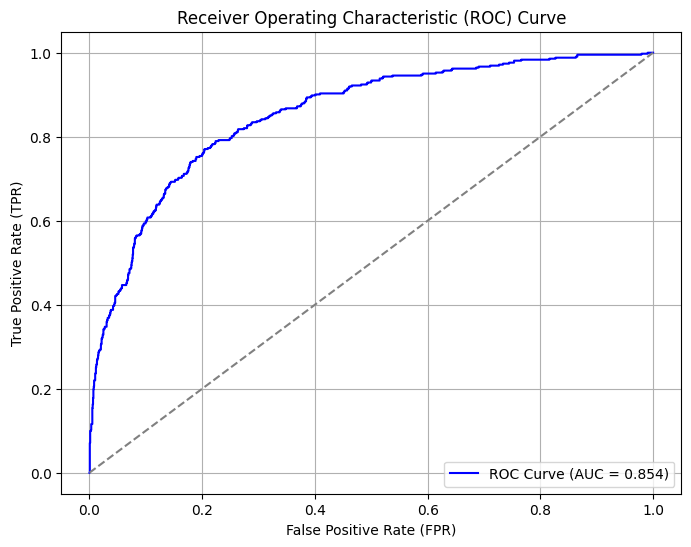

In [24]:
# Calculate AUC-ROC score for plot legend
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

# Calculate FPR, TPR, and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

# Plotting ROC curve of final model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Confusion Matrix (count and percentage) of final model on Test dataset:

|          | Didn't Exit   | Exited   |
|:--------------:|:--------------:|:--------------:|
| **Correct** | 1349 (67.45%)  |  228 (11.40%)   |
| **Incorrect**  | 130 (6.50%)  |  293 (14.65%)    |


Summary of performance metrics between Validation and Test datasets for final model:

| Dataset Tested    | Accuracy    | Recall    | Precision  | F1 Score   | AUC-ROC Score   |
|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
| **Validation** | 0.823  | 0.687  | 0.563  | 0.619 | 0.844 |
| **Test**  | 0.821  | 0.693  | 0.562  | 0.621  | 0.854 |

This model meets the threshold for acceptance (F1 score >= 0.59). 

Some observations when comparing model predictions for the Test versus Validation datasets:
- There is a slight decrease in Accuracy and Precision
- There is a slight increase in Recall, F1 Score, and AUC-ROC Score
- Both datasets yielded F1 Scores exceeding our minimum acceptable value of 0.59.
- An AUC-ROC Score between 0.8-0.9 can generally be interpreted as a 'very good' performing model.

## Conclusion

### Summary

Beta Bank customers are slowly closing their accounts and leaving the bank. It has been discovered that it is cheaper to retain existing customers than to attract new ones. I work as an analyst for Beta Bank and have been tasked with predicting whether a customer will leave the bank soon in order to attempt to keep them.

### Objective

I was tasked with creating a model to accurately predict customers exiting the bank with a maxmimum possible F1 Score (minimum acceptable: 0.59).

### Outcome and Findings

I have created a model that will be able to identify customers at risk of ending their relationship with the bank with an accuracy of 82.1%. Further, the model produced an F1 Score of 0.621 during testing, meeting the requirements of the task. Finally, its AUC-ROC Score of 0.854 demonstrates that it can be generally described as a 'very good' model of the data.

**Final Model:**
> - Random Forest Classifier algorithm
> - Parameters
>    - n_estimators=20
>    - max_depth=10
>    - class_weight='balanced'
> - Model training using upsampled training dataset

Using this model with other customer data will allow us to direct promotions, marketing, outreach, and other strategies aimed at retaining these customers. This approach will be cheaper than attempting to attract new customers and will benefit Beta Bank's business greatly.